In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

1732


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear'

folders, fovs = ia.io_tools.data.get_folders(data_folder)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 25
- Number of field of views: 138


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [9]:

for _fov_id, _fov_name in enumerate(fovs):
    if _fov_id < 50:
        continue
    _save_id = _fov_id - 50    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    print(f"- seg file: {seg_save_file}")
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], 
                                    #diameter=25, 
                                    min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    corr_labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(corr_labels3d.shape, _fov_id, _save_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    #break

- seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_0.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_050.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_050.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.815s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.277s.
-- corrected illumination for channel 405 in 4.308s.
- Finished illumination correction in 8.776s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\202205

## Check result

<IPython.core.display.Javascript object>


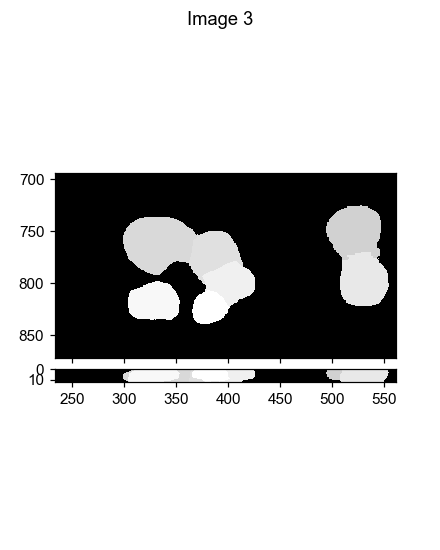

In [23]:
visual_tools.imshow_mark_3d_v2([test_dapi_im, test_polyt_im, labels3d])

# Run watershed

In [10]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [12]:
for _fov_id, _fov_name in enumerate(fovs):
    if _fov_id < 50:
        continue
    _save_id = _fov_id - 50    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file)
    
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    new_labels = ndimage.grey_dilation(new_labels, structure=morphology.ball(1))
    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )


- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_1.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_051.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_051.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_051.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.364s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 5.213s.
-- corrected illumination for channel 405 in 5.005s.
- Finished illumination correction in 10.241s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\

- Loaded images for channels:['750', '488'] in 1.260s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.126s.
-- corrected illumination for channel 488 in 1.123s.
- Finished illumination correction in 2.314s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03  -2.94 -21.74] in 0.570s.
-- drift 1: [-2.000e-02 -3.010e+00 -2.174e+01] in 0.572s.
-- drift 2: [ -0.03  -2.78 -21.7 ] in 0.573s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.02666667  -2.91       -21.72666667] for channel: 750
-- finish warpping channel 750 in 16.339s.
488 False True
-- warp image with drift:[ -0.02666667  -2.91       -21.72666

- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_8.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_058.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_058.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_058.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.852s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.497s.
-- corrected illumination for channel 405 in 4.495s.
- Finished illumination correction in 9.121s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\2

- Loaded images for channels:['750', '488'] in 1.237s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.243s.
-- corrected illumination for channel 488 in 1.122s.
- Finished illumination correction in 2.477s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -2.49 15.6 ] in 0.664s.
-- drift 1: [-0.06 -2.84 15.8 ] in 0.629s.
-- drift 2: [-0.04 -2.68 15.8 ] in 0.656s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04333333 -2.67       15.73333333] for channel: 750
-- finish warpping channel 750 in 16.641s.
488 False True
-- warp image with drift:[-0.04333333 -2.67       15.73333333] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_15.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_065.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_065.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_065.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.741s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.267s.
-- corrected illumination for channel 405 in 4.257s.
- Finished illumination correction in 8.637s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\

- Loaded images for channels:['750', '488'] in 1.231s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.115s.
-- corrected illumination for channel 488 in 1.117s.
- Finished illumination correction in 2.250s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -4.64 16.41] in 0.561s.
-- drift 1: [-1.000e-02 -4.550e+00  1.618e+01] in 0.579s.
-- drift 2: [-1.00e-02 -4.50e+00  1.64e+01] in 0.575s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-6.66666667e-03 -4.56333333e+00  1.63300000e+01] for channel: 750
-- finish warpping channel 750 in 16.356s.
488 False True
-- warp image with drift:[-6.66666667e-03 -4.5

- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_21.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_22.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_072.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_072.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_072.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.412s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.292s.
-- corrected illumination for cha

- Loaded images for channels:['750', '488'] in 1.182s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.113s.
-- corrected illumination for channel 488 in 1.132s.
- Finished illumination correction in 2.309s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -6.92 11.43] in 0.603s.
-- drift 1: [-0.04 -6.94 11.53] in 0.564s.
-- drift 2: [-0.03 -7.06 11.67] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04       -6.97333333 11.54333333] for channel: 750
-- finish warpping channel 750 in 16.318s.
488 False True
-- warp image with drift:[-0.04       -6.97333333 11.54333333] for channel: 488
-- fi

- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_29.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_079.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_079.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_079.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.795s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.299s.
-- corrected illumination for channel 405 in 4.311s.
- Finished illumination correction in 8.817s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\

-- corrected illumination for channel 750 in 1.130s.
-- corrected illumination for channel 488 in 1.121s.
- Finished illumination correction in 2.361s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -4.72 14.76] in 0.558s.
-- drift 1: [-0.03 -4.91 14.73] in 0.571s.
-- drift 2: [-0.05 -4.7  14.81] in 0.573s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03666667 -4.77666667 14.76666667] for channel: 750
-- finish warpping channel 750 in 16.302s.
488 False True
-- warp image with drift:[-0.03666667 -4.77666667 14.76666667] for channel: 488
-- finish warpping channel 488 in 16.342s.
-- finish warpping in 32.645s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_32.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308

- Loaded images for channels:['488', '405'] in 6.190s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.356s.
-- corrected illumination for channel 405 in 4.335s.
- Finished illumination correction in 8.787s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_086.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.302s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.181s.
-- corrected illumination for channel 488 in 1.144s.
- 

-- drift 0: [ 1.000e-02 -3.460e+00  1.437e+01] in 0.595s.
-- drift 1: [ 1.000e-02 -3.580e+00  1.436e+01] in 0.556s.
-- drift 2: [ 1.000e-02 -3.510e+00  1.437e+01] in 0.585s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -3.51666667e+00  1.43666667e+01] for channel: 750
-- finish warpping channel 750 in 16.270s.
488 False True
-- warp image with drift:[ 1.00000000e-02 -3.51666667e+00  1.43666667e+01] for channel: 488
-- finish warpping channel 488 in 16.412s.
-- finish warpping in 32.683s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_39.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_40.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_090.dax \\10.245.74.158\Chromatin_NAS_6\20220525-h

- Loaded images for channels:['488', '405'] in 6.153s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.545s.
-- corrected illumination for channel 405 in 4.590s.
- Finished illumination correction in 9.154s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_093.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.166s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.123s.
-- corrected illumination for channel 488 in 1.105s.
- 

-- drift 0: [ 0.  -4.8 10.9] in 0.579s.
-- drift 1: [ 0.   -4.77 10.9 ] in 0.566s.
-- drift 2: [ 0.   -4.71 10.71] in 0.577s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -4.76       10.83666667] for channel: 750
-- finish warpping channel 750 in 16.306s.
488 False True
-- warp image with drift:[ 0.         -4.76       10.83666667] for channel: 488
-- finish warpping channel 488 in 16.331s.
-- finish warpping in 32.638s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_46.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_47.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_097.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_097.dax
Initialize DaxProcesse

- Loaded images for channels:['488', '405'] in 5.897s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.393s.
-- corrected illumination for channel 405 in 4.611s.
- Finished illumination correction in 9.219s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_100.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.269s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.219s.
-- corrected illumination for channel 488 in 1.157s.
- 

-- drift 1: [-1.000e-02 -5.250e+00  1.559e+01] in 0.578s.
-- drift 2: [ 0.   -5.07 15.73] in 0.589s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -5.11333333 15.64      ] for channel: 750
-- finish warpping channel 750 in 16.372s.
488 False True
-- warp image with drift:[ 0.         -5.11333333 15.64      ] for channel: 488
-- finish warpping channel 488 in 16.361s.
-- finish warpping in 32.733s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_53.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_54.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_104.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_104.dax
Initialize DaxProcesser for file:\\10.245.74.15

- Loaded images for channels:['488', '405'] in 5.932s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.275s.
-- corrected illumination for channel 405 in 4.355s.
- Finished illumination correction in 8.731s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_107.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.241s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.134s.
-- corrected illumination for channel 488 in 1.153s.
- 

-- drift 0: [-0.02 -4.44 15.72] in 0.590s.
-- drift 1: [-1.000e-02 -4.660e+00  1.574e+01] in 0.591s.
-- drift 2: [-1.00e-02 -4.61e+00  1.57e+01] in 0.581s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.33333333e-02 -4.57000000e+00  1.57200000e+01] for channel: 750
-- finish warpping channel 750 in 16.296s.
488 False True
-- warp image with drift:[-1.33333333e-02 -4.57000000e+00  1.57200000e+01] for channel: 488
-- finish warpping channel 488 in 16.301s.
-- finish warpping in 32.598s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_60.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_61.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_111.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_no

- Loaded images for channels:['488', '405'] in 6.024s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.284s.
-- corrected illumination for channel 405 in 4.293s.
- Finished illumination correction in 8.697s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_114.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.226s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.087s.
-- corrected illumination for channel 488 in 1.124s.
- 

-- drift 0: [-1.000e-02 -5.220e+00  3.081e+01] in 0.585s.
-- drift 1: [-1.00e-02 -5.37e+00  3.09e+01] in 0.588s.
-- drift 2: [ 0.   -5.21 30.71] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-6.66666667e-03 -5.26666667e+00  3.08066667e+01] for channel: 750
-- finish warpping channel 750 in 16.394s.
488 False True
-- warp image with drift:[-6.66666667e-03 -5.26666667e+00  3.08066667e+01] for channel: 488
-- finish warpping channel 488 in 16.413s.
-- finish warpping in 32.808s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_67.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_68.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_118.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_no

- Loaded images for channels:['488', '405'] in 6.427s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.296s.
-- corrected illumination for channel 405 in 4.299s.
- Finished illumination correction in 8.744s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_121.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.172s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.089s.
-- corrected illumination for channel 488 in 1.107s.
- 

-- drift 0: [-0.03 -5.16 15.88] in 0.545s.
-- drift 1: [-0.02 -5.33 15.8 ] in 0.574s.
-- drift 2: [-0.04 -5.38 16.17] in 0.589s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03 -5.29 15.95] for channel: 750
-- finish warpping channel 750 in 16.298s.
488 False True
-- warp image with drift:[-0.03 -5.29 15.95] for channel: 488
-- finish warpping channel 488 in 16.365s.
-- finish warpping in 32.664s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_74.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_75.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_125.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_125.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chroma

-- corrected illumination for channel 488 in 4.335s.
-- corrected illumination for channel 405 in 4.548s.
- Finished illumination correction in 9.109s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_128.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.186s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.264s.
-- corrected illumination for channel 488 in 1.299s.
- Finished illumination correction in 2.667s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.18 -5.41 20.29] in 0.559s.
-- drift 1: [-0.03 -5.4  20.5 ] in 0.575s.
-- drift 2: [-0.11 -5.37 20.51]

-- warp image with drift:[-0.03       -3.94       14.21333333] for channel: 750
-- finish warpping channel 750 in 16.274s.
488 False True
-- warp image with drift:[-0.03       -3.94       14.21333333] for channel: 488
-- finish warpping channel 488 in 16.389s.
-- finish warpping in 32.664s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_81.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Segmentation\segmentation_label_82.npy
\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_132.dax \\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_132.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H0M1\Conv_zscan_132.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 6.052s.
- Sta

-- corrected illumination for channel 488 in 4.286s.
-- corrected illumination for channel 405 in 4.281s.
- Finished illumination correction in 8.687s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\H24M25\Conv_zscan_135.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.263s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.106s.
-- corrected illumination for channel 488 in 1.190s.
- Finished illumination correction in 2.353s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -4.190e+00  2.176e+01] in 0.541s.
-- drift 1: [-2.000e-02 -4.320e+00  2.175e+01] in 0.615s.
-

In [59]:
from scipy import ndimage


<IPython.core.display.Javascript object>


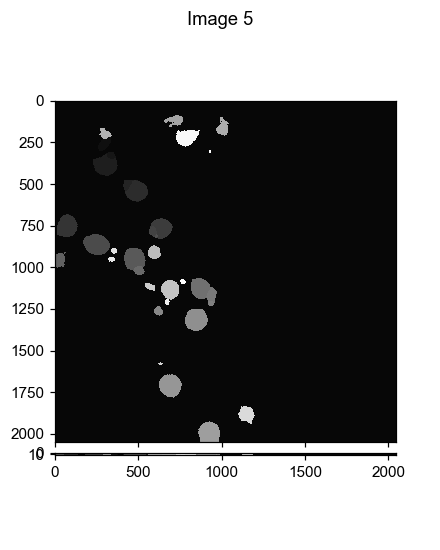

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask, corr_labels3d, new_labels])

# check merlin outputs

In [14]:
import h5py

In [66]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG_test\CellPoseSegment\features\feature_data_0.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


<IPython.core.display.Javascript object>


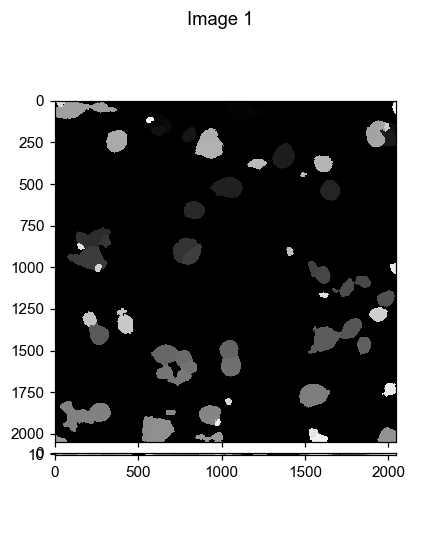

In [67]:
visual_tools.imshow_mark_3d_v2([watershed_labels])

In [8]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG\CellPoseSegment\features\feature_data_80.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    new_watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


In [46]:
from skimage import segmentation

new_labels = segmentation.watershed(
                waterIm, old_label3d, mask=waterMask,
                connectivity=np.ones((3, 3, 3)), watershed_line=True)

<IPython.core.display.Javascript object>


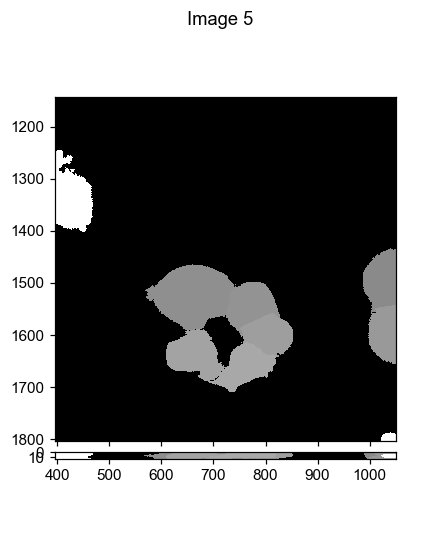

In [47]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask, old_label3d, new_labels])

In [71]:
relabel_info = pickle.load(open(r'E:\Processed_Data_Backup\202003_IMR90_chr2_repeat_relabelling\picked_relabeled_spot_pairs_2-71.pkl','rb'))

In [ ]:
visual_tools

In [85]:
relabe_zxys

array([[[2.44868031e+03, 4.69997054e+03, 7.23436359e+03, 7.48437071e+00],
        [3.73104439e+03, 4.62864729e+03, 7.40921924e+03, 2.39197063e+00],
        [2.24792957e+03, 4.69036958e+03, 7.14845435e+03, 1.58881152e+00],
        ...,
        [2.64051418e+03, 3.11798666e+03, 6.11022821e+03, 9.19883347e+00],
        [2.63617077e+03, 3.07044704e+03, 6.22241441e+03, 7.41383934e+00],
        [2.26103153e+03, 3.21625182e+03, 6.25290601e+03, 3.86180091e+00]],

       [[2.16445065e+03, 3.13107282e+03, 1.01894727e+04, 8.00683212e+00],
        [3.10189037e+03, 4.85165479e+03, 1.02543698e+04, 5.19267321e+00],
        [2.81243649e+03, 4.97361086e+03, 1.03899894e+04, 2.71444392e+00],
        ...,
        [2.79996834e+03, 3.67189906e+03, 1.06949391e+04, 2.33186173e+00],
        [2.76656399e+03, 3.55870226e+03, 1.10467400e+04, 4.68488646e+00],
        [2.73376083e+03, 3.81614900e+03, 1.05940896e+04, 1.11110854e+00]],

       [[2.97902107e+03, 1.35271961e+04, 9.24907709e+03, 2.12193418e+00],
        

In [83]:
relabe_zxys = np.load(r'\\10.245.74.158\Chromatin_NAS_4\2020_cell_materials\Chromatin_Share\Repicked_chromosome_data\before_20200512\zxyhs_final_EM_chr21_relabel.npy')

In [82]:
relabel_info['old'][1][0]

array([[ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.88830070e+01,  2.29775448e+01,  1.74338776e+02, ...,
        -6.78960886e-03, -6.34057760e-01,  5.79653076e+02],
       ...,
       [ 2.60387554e+01,  2.41951199e+01,  1.68056412e+02, ...,
         1.13709886e-02,  8.33605453e-02,  6.47226807e+02],
       [ 4.13785648e+00,  2.30000000e+01,  1.66000000e+02, ...,
         2.44903816e-07,  4.09684958e-07,  4.69725189e+02],
       [ 1.32260017e+01,  2.31380005e+01,  1.71030380e+02, ...,
         4.81985718e-01, -4.74240720e-01,  3.35760864e+02]])

In [79]:
len(relabel_info['old'][1][0])

357

In [78]:
len(relabel_info['new'][0][0])

357

In [46]:
!dir ..\..\S

 Volume in drive E is Data_01
 Volume Serial Number is B8F1-585C

 Directory of E:\Users\puzheng\Documents

05/28/2022  01:00 AM    <DIR>          .
05/28/2022  01:00 AM    <DIR>          ..
10/20/2020  12:30 AM    <DIR>          Chromatin_Analysis_2020_cell
05/26/2022  04:03 PM    <DIR>          Chromatin_Analysis_Scripts
10/20/2020  12:23 AM    <DIR>          Codes
05/26/2022  04:55 PM    <DIR>          ConvNeXt
10/20/2020  12:23 AM    <DIR>          Custom Office Templates
12/18/2020  10:12 PM             1,276 debug.log
10/20/2020  12:23 AM    <DIR>          dna-analysis
10/20/2020  12:23 AM    <DIR>          Hi-C
05/26/2022  03:09 PM    <DIR>          ImageAnalysis3
05/28/2022  01:00 AM    <DIR>          Insight3
05/27/2022  12:55 PM    <DIR>          Merfish_Analysis_Scripts
05/27/2022  12:55 PM    <DIR>          MERlin
05/26/2022  03:40 PM    <DIR>          OneNote Notebooks
05/26/2022  02:37 PM    <DIR>          Python Scripts
10/20/2020  12:23 AM    <DIR>          rdpwrap
09/3